### Importing Libraries

In [15]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### Importing Dataset

In [16]:
im_width = 256
im_height = 256

image_filename_train = []

mask_files = glob(pathname="C:/Users/HP/Downloads/dataset_bts/kaggle_3m/*/*_mask*")
for i in mask_files:
    image_filename_train.append(i.replace('_mask',''))
print(image_filename_train[:10])

['C:/Users/HP/Downloads/dataset_bts/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', 'C:/Users/HP/Downloads/dataset_bts/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', 'C:/Users/HP/Downloads/dataset_bts/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', 'C:/Users/HP/Downloads/dataset_bts/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', 'C:/Users/HP/Downloads/dataset_bts/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', 'C:/Users/HP/Downloads/dataset_bts/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', 'C:/Users/HP/Downloads/dataset_bts/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', 'C:/Users/HP/Downloads/dataset_bts/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', 'C:/Users/HP/Downloads/dataset_bts/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', 'C:/Users/HP/Downloads/dataset_bts/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_19.tif']

### Preprocessing the Data

In [17]:
df = pd.DataFrame(data = {'image_filename_train': image_filename_train, 'mask': mask_files})
df_train, df_test = train_test_split(df, test_size = 0.05)
df_train, df_val = train_test_split(df_train, test_size = 0.05)

In [18]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):

    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filename_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
      if img.size == 0 or mask.size == 0:
          print("Skipping empty batch!")
          continue
      img, mask = normalize_and_diagnose(img, mask)
      yield (img, mask)

In [19]:
@tf.keras.utils.register_keras_serializable()
def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)
@tf.keras.utils.register_keras_serializable()
def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)
@tf.keras.utils.register_keras_serializable()
def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

### Evaluating the Model

In [20]:
model = load_model(r"C:\Users\HP\Downloads\unet_brain_mri_seg_.keras")

In [21]:
test_gen = train_generator(df_test, 32, dict(), target_size=(im_height,im_width))

results = model.evaluate(test_gen, steps = int(len(df_test)/32))
print('Test Loss', results[0])
print('Test IOU', results[1])
print('Test Dice Coeff', results[2])

Found 197 validated image filenames.
Found 197 validated image filenames.
6/6 ━━━━━━━━━━━━━━━━━━━━ 123s 21s/step - binary_accuracy: 0.9976 - dice_coefficients: 0.8380 - iou: 0.7229 - loss: -0.8380
Test Loss -0.8517379760742188
Test IOU 0.9976665377616882
Test Dice Coeff 0.7445054054260254


### Moment of Truth

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


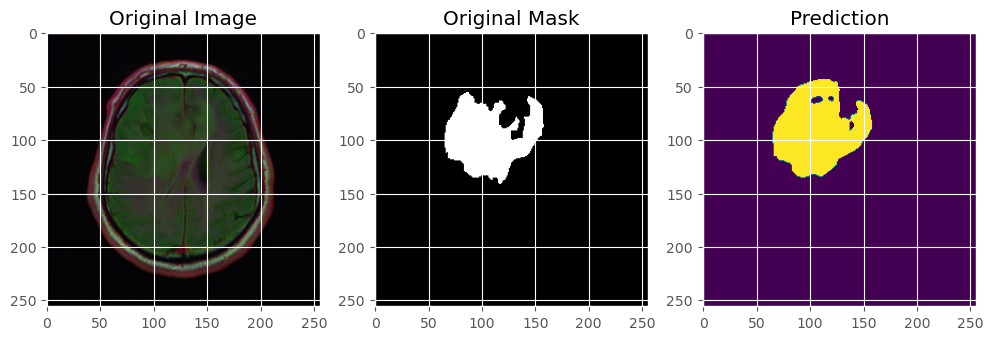

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


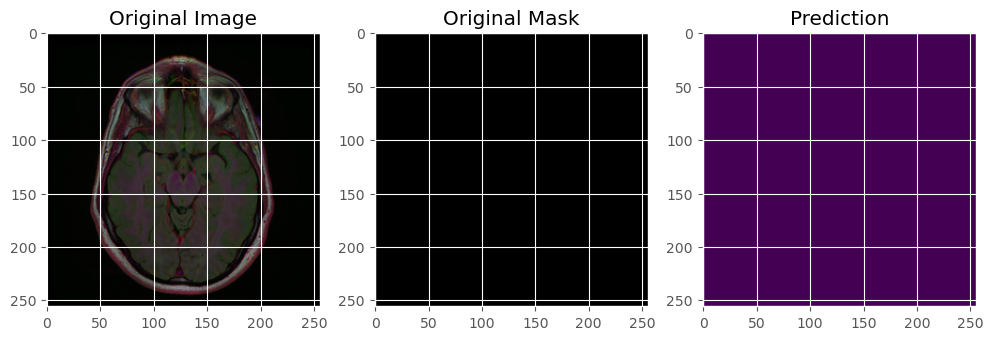

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


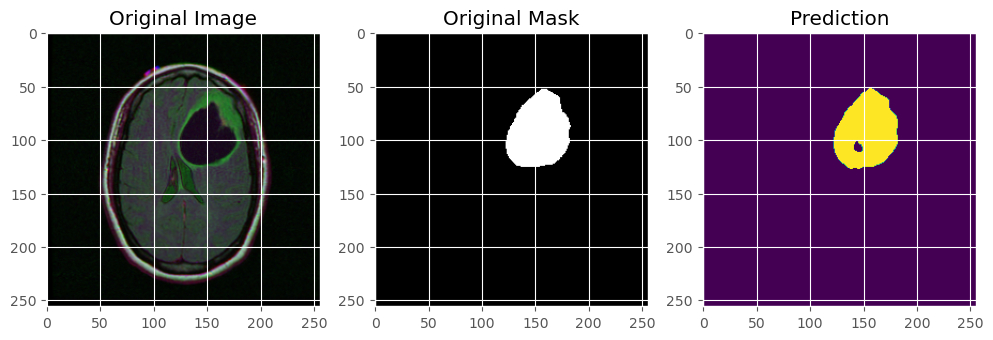

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


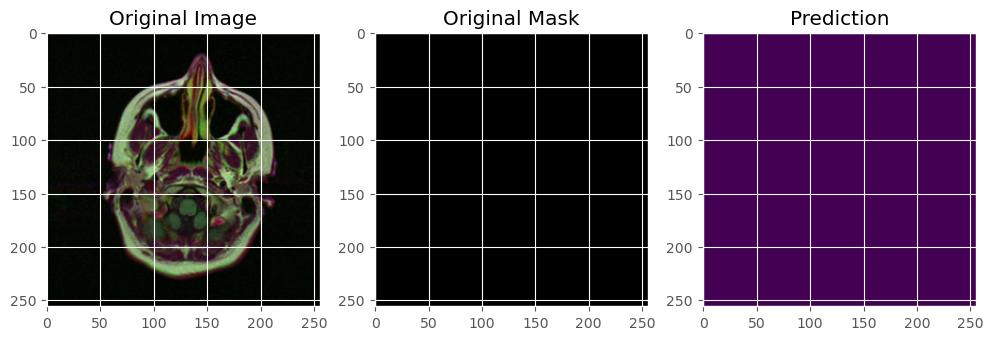

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


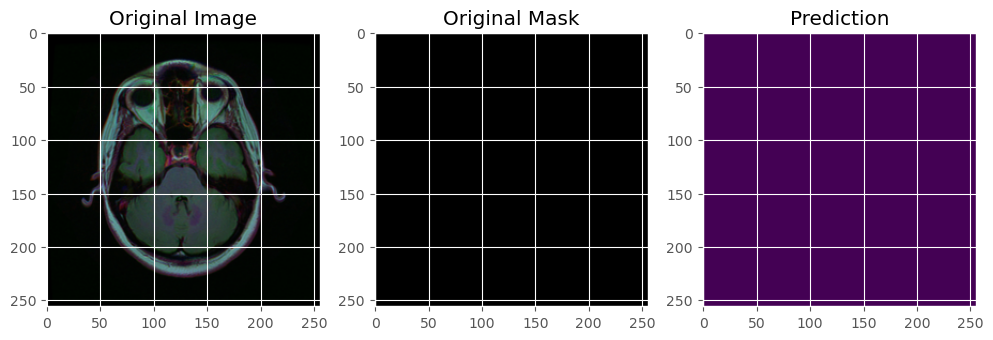

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


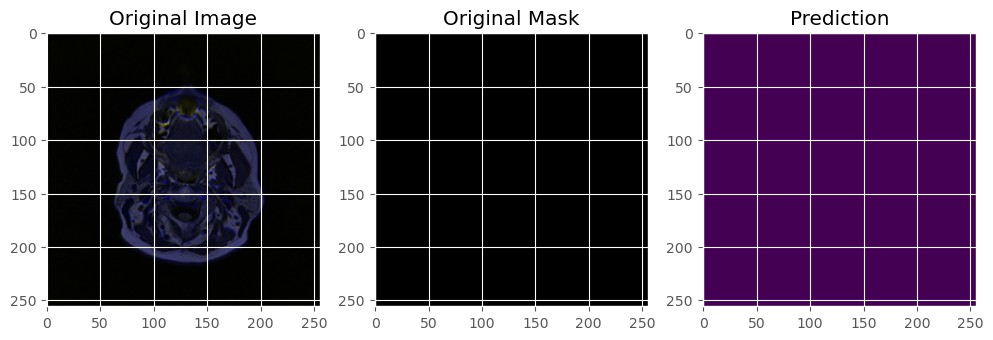

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


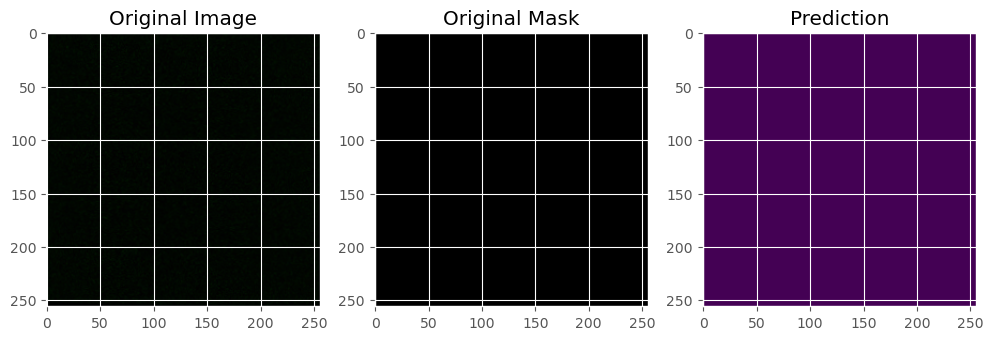

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


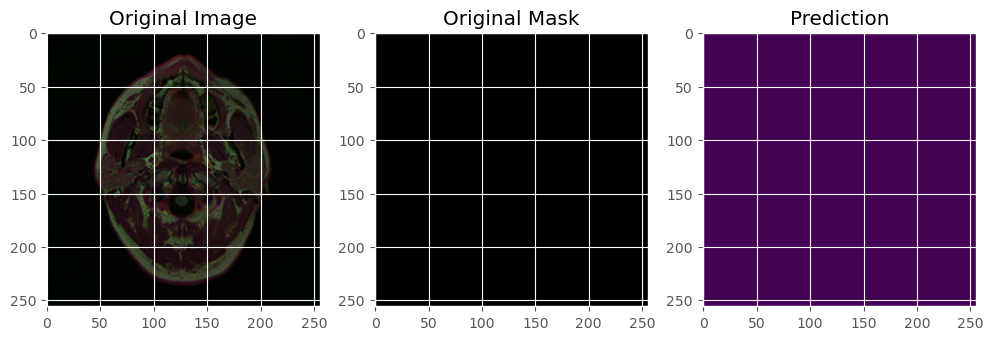

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


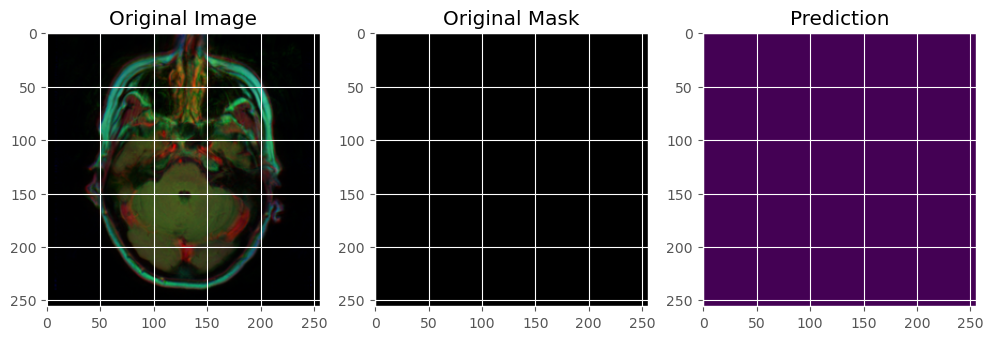

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


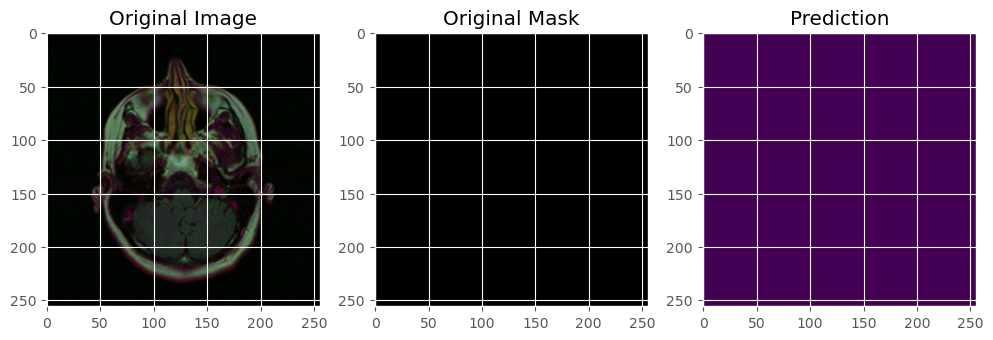

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


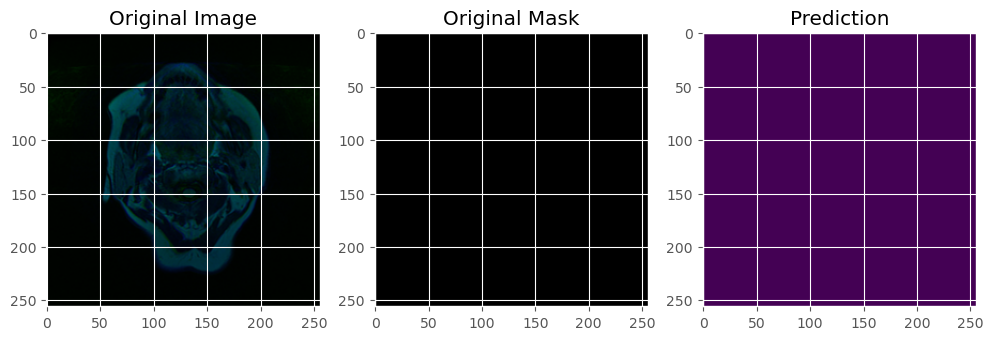

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


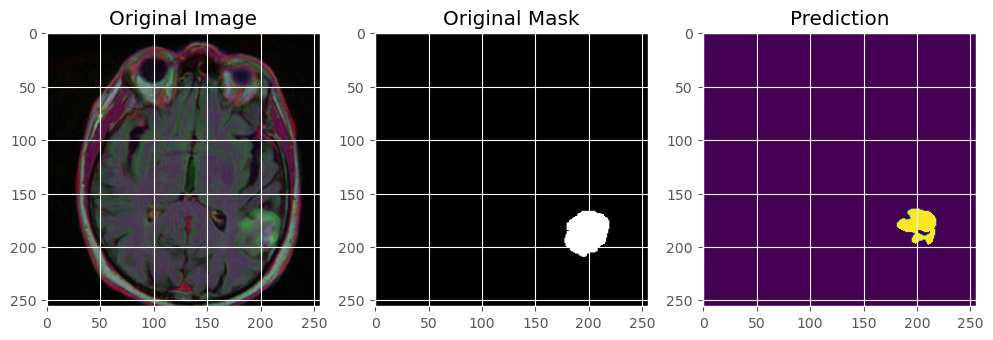

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


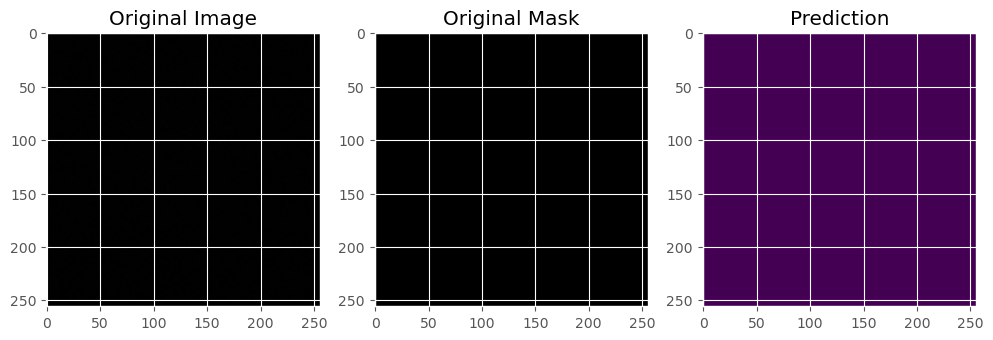

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


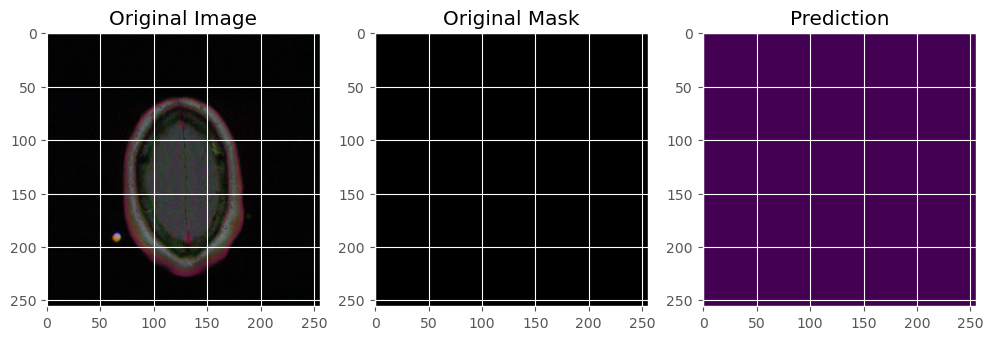

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


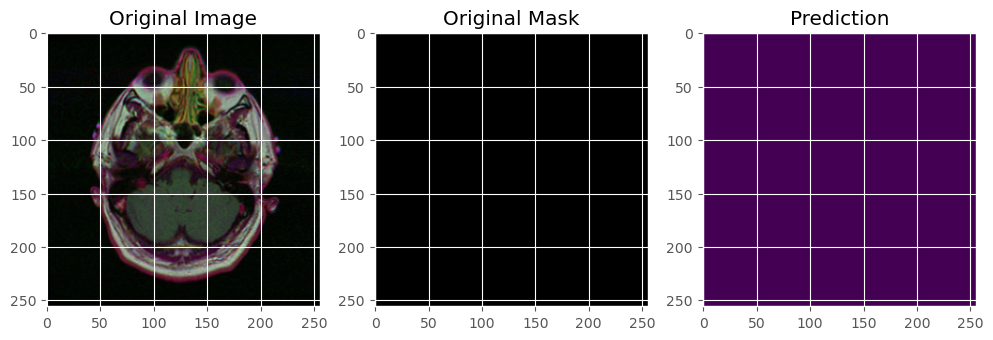

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


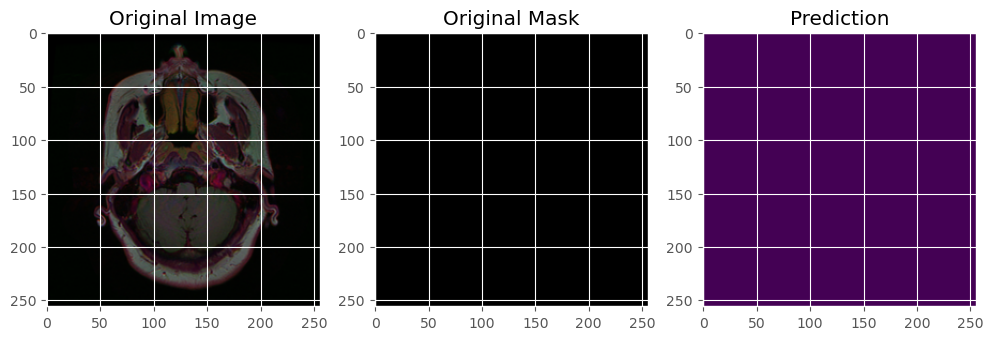

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


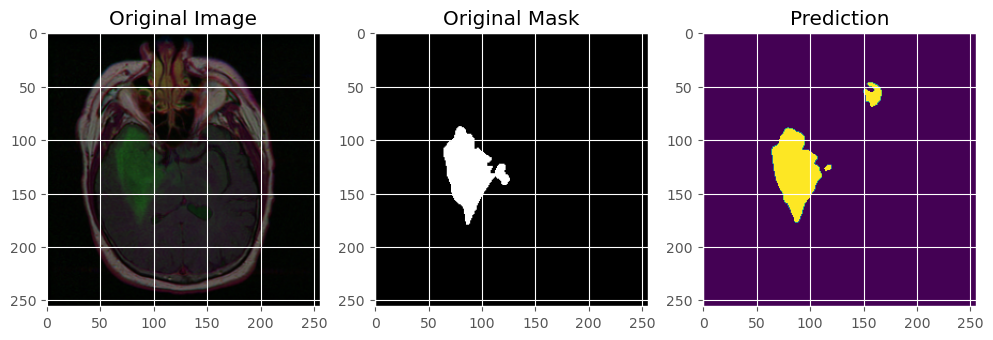

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


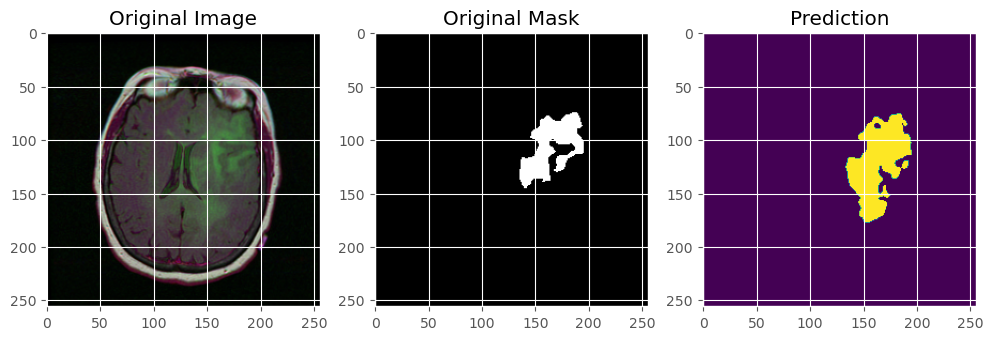

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


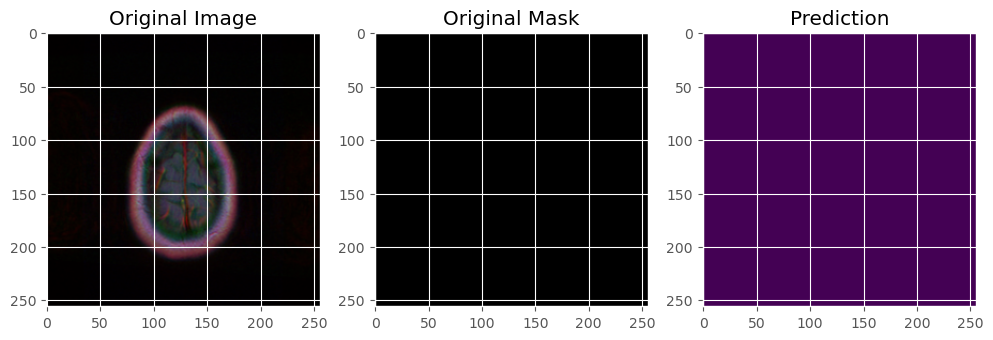

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


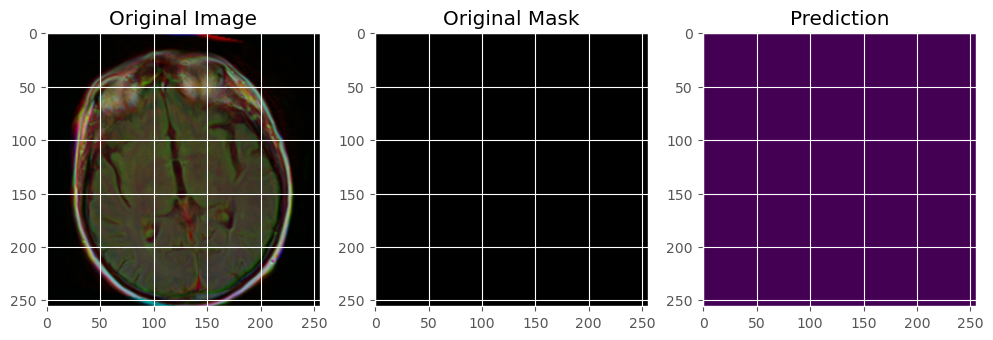

In [22]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filename_train'].iloc[index])
    img = cv2.resize(img, (im_height,im_width))
    img = img/255
    img = img[np.newaxis, : ,:, :]
    pred_img = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img) > 0.5)
    plt.title("Prediction")
    plt.show()